## Classifying Data Jobs

Team: Charis Chan, Joyce Ching, Inderpal Kaur

In [70]:
import pandas as pd
import numpy as np
import re
import folium
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# About the Data
- scraped from Glassdoor job postings Jun. 2020
(https://github.com/picklesueat/data_jobs_data)
- searched by keyword 'Data Scientist', 'Data Analyst', 'Data Engineer'

In [71]:
!wget https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataScientist.csv
!wget https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataAnalyst.csv
!wget https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataEngineer.csv

--2020-12-08 04:44:55--  https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataScientist.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14957616 (14M) [text/plain]
Saving to: ‘DataScientist.csv.2’

DataScientist.csv.2 100%[===================>]  14.26M  69.8MB/s    in 0.2s    

2020-12-08 04:44:55 (69.8 MB/s) - ‘DataScientist.csv.2’ saved [14957616/14957616]

--2020-12-08 04:44:55--  https://raw.githubusercontent.com/picklesueat/data_jobs_data/master/DataAnalyst.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1954

In [72]:
scientist = pd.read_csv('DataScientist.csv').drop(columns=['Unnamed: 0', 'index'])
analyst = pd.read_csv('DataAnalyst.csv')
engineer = pd.read_csv('DataEngineer.csv')

In [73]:
scientist['Label'] = 'Data Scientist'
analyst['Label'] = 'Data Analyst'
engineer['Label'] = 'Data Engineer'

In [74]:
scientist.shape

(3909, 16)

In [75]:
analyst.shape

(5631, 16)

In [76]:
engineer.shape

(2528, 16)

In [77]:
all_data = pd.concat([analyst,scientist,engineer])

In [78]:
all_data.shape

(12068, 16)

In [79]:
all_data.head(3)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,Label
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,Data Analyst
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,Data Analyst
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,Data Analyst


# Data Cleaning
- remove duplicates
- clean up `Company Name`
- bin `Revenue` and `Size`
- convert `Salary Estimate` to integers
- make `Job Description` lower case
- extract level of seniority
- map `Location`

### Remove duplicate job postings

In [80]:
df = all_data.drop_duplicates(subset=['Job Title', 'Salary Estimate', 'Job Description', 
                                      'Company Name', 'Location', 'Industry', 'Sector',
                                      'Easy Apply']).reset_index(drop=True)
df.head(3)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,Label
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,Data Analyst
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,Data Analyst
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,Data Analyst


In [81]:
df.shape # took out 15 jobs

(12053, 16)

### Clean up `Company Name` by removing ratings

In [82]:
# taking out rating from company name
for i in range(len(df)):
    try:
        df.loc[i, 'Company Name'] = re.sub('\\n\d\.\d', '', df.loc[i, 'Company Name'])
    except TypeError:
        continue

df.head(3)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,Label
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,Data Analyst
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,Data Analyst
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,Data Analyst


### Make bins for company `Revenue`

| Revenue                               | Bin |
|---------------------------------------|-----|
|'Less than \\$1 million (USD)'         | 1   |
|'\\$1 to \\$5 million (USD)'           | 2   |
|'\\$5 to \\$10 million (USD)'          | 3   |
|'\\$10 to \\$25 million (USD)'         | 4   |
|'\\$25 to \\$50 million (USD)'         | 5   |
|'\\$50 to \\$100 million (USD)'        | 6   |
|'\\$100 to \\$500 million (USD)'       | 7   |
|'\\$500 million to \\$1 billion (USD)' | 8   |
|'\\$1 to \\$2 billion (USD)'           | 9   |
|'\\$2 to \\$5 billion (USD)'           | 10  |
|'\\$5 to \\$10 billion (USD)'          | 11  |
|'\\$10+ billion (USD)'                 | 12  |
|'Unknown / Non-Applicable' or '-1'     | NaN |

In [83]:
# Revenue is neatly categorized. 
# We just need to convert it into ordinal values that we can work with.
df["Revenue"].value_counts()

Unknown / Non-Applicable            3326
$10+ billion (USD)                  1499
$100 to $500 million (USD)          1179
$50 to $100 million (USD)            907
-1                                   713
$10 to $25 million (USD)             662
$2 to $5 billion (USD)               647
$25 to $50 million (USD)             568
$1 to $5 million (USD)               538
$1 to $2 billion (USD)               513
$5 to $10 billion (USD)              401
Less than $1 million (USD)           384
$500 million to $1 billion (USD)     380
$5 to $10 million (USD)              336
Name: Revenue, dtype: int64

In [84]:
# map Revenue to ordinal variables
rev_mapper = {'Unknown / Non-Applicable': np.nan, '-1': np.nan, 'Less than $1 million (USD)': 1, 
              '$1 to $5 million (USD)': 2, '$5 to $10 million (USD)': 3, '$10 to $25 million (USD)': 4, 
              '$25 to $50 million (USD)': 5, '$50 to $100 million (USD)': 6, '$100 to $500 million (USD)': 7, 
              '$500 million to $1 billion (USD)': 8, '$1 to $2 billion (USD)': 9, '$2 to $5 billion (USD)': 10, 
              '$5 to $10 billion (USD)': 11, '$10+ billion (USD)': 12}
df.loc[:, 'Ordinal Revenue'] = df.loc[:, 'Revenue'].replace(rev_mapper)

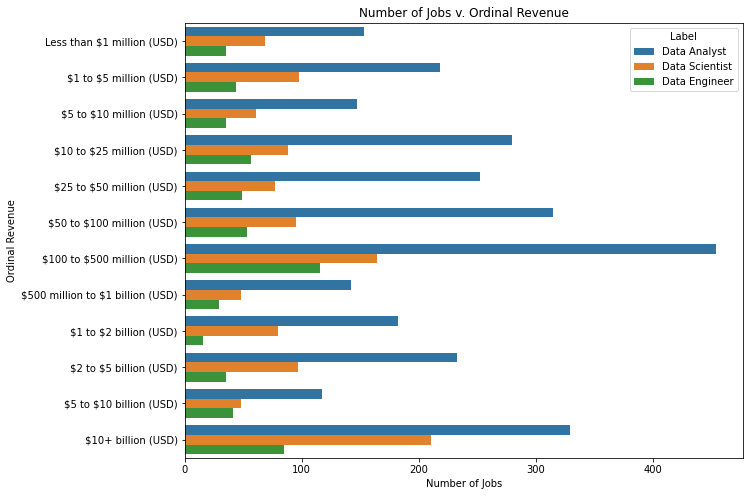

In [85]:
unique_companies = df.drop_duplicates(subset=['Company Name', 'Location', 'Sector'])
labels=['Less than \\$1 million (USD)', '\\$1 to \\$5 million (USD)',
        '\\$5 to \\$10 million (USD)', '\\$10 to \\$25 million (USD)', 
        '\\$25 to \\$50 million (USD)', '\\$50 to \\$100 million (USD)', 
        '\\$100 to \\$500 million (USD)', '\\$500 million to \\$1 billion (USD)', 
        '\\$1 to \\$2 billion (USD)', '\\$2 to \\$5 billion (USD)', 
        '\\$5 to \\$10 billion (USD)', '\\$10+ billion (USD)']

#plt.hist(unique_companies['Ordinal Revenue'], bins=12, orientation="horizontal")
plt.figure(figsize=(10, 8))
sns.countplot(y='Ordinal Revenue', hue="Label", data=unique_companies)
plt.title('Number of Jobs v. Ordinal Revenue')
plt.yticks(np.arange(0, 12), labels=labels)
plt.ylabel('Ordinal Revenue')
plt.xlabel('Number of Jobs');

### Make bins for company `Size`

| Size                     | Bin  |
|--------------------------|------|
|'1 to 50 employees'       |  1   |
|'51 to 200 employees'     |  2   |
|'201 to 500 employees'    |  3   |
|'501 to 1000 employees'   |  4   |
|'1001 to 5000 employees'  |  5   |
|'5001 to 10000 employees' |  6   |
|'10000+ employees'        |  7   |
|'Unknown' or '-1'         |  NaN |

In [86]:
# there are 7 categories of company sizes
# we convert the strings into ordinal data using the mapping above
df['Size'].value_counts()

10000+ employees           2571
51 to 200 employees        2106
1001 to 5000 employees     1835
1 to 50 employees          1675
201 to 500 employees       1240
501 to 1000 employees      1017
-1                          713
5001 to 10000 employees     657
Unknown                     239
Name: Size, dtype: int64

In [87]:
size_mapping = {'1 to 50 employees': 1, '51 to 200 employees': 2, '201 to 500 employees': 3, 
 '501 to 1000 employees': 4, '1001 to 5000 employees': 5, '5001 to 10000 employees': 6, 
 '10000+ employees': 7, 'Unknown': np.nan, '-1': np.nan}

df.loc[:, "Ordinal Size"] = df.loc[:, 'Size'].map(size_mapping)
df["Ordinal Size"].value_counts()

7.0    2571
2.0    2106
5.0    1835
1.0    1675
3.0    1240
4.0    1017
6.0     657
Name: Ordinal Size, dtype: int64

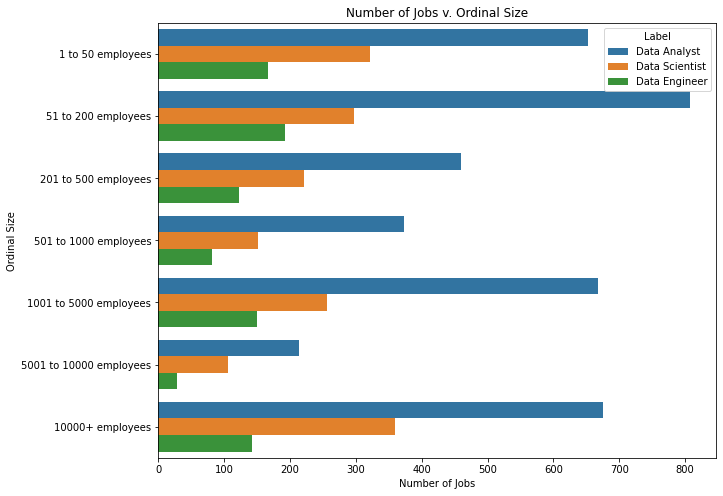

In [88]:
unique_companies = df.drop_duplicates(subset=['Company Name', 'Location', 'Sector'])
labels=['1 to 50 employees', '51 to 200 employees', '201 to 500 employees', 
        '501 to 1000 employees', '1001 to 5000 employees', '5001 to 10000 employees', 
        '10000+ employees']

plt.figure(figsize=(10, 8))
sns.countplot(y='Ordinal Size', hue="Label", data=unique_companies)
plt.title('Number of Jobs v. Ordinal Size')
plt.yticks(np.arange(0, 7), labels=labels)
plt.ylabel('Ordinal Size')
plt.xlabel('Number of Jobs');

### Convert `Salary Estimate` to integers

In [89]:
# Salary Estimate Beginning Range
# Salary Estimate End Range
sal_beg_est = []
sal_end_est = []
for i in range(len(df)):
    sal_est = df['Salary Estimate'][i]
    if sal_est == '-1':
        beg = np.nan
        end = np.nan
    else:
        sal = re.split(r'\-', sal_est)
        # avg working hours per yr in USA: 1,768 hours 
        if re.search('Hour', sal_est):
            beg = int(re.findall(r'\d+',sal[0])[0])*1768
            end = int(re.findall(r'\d+',sal[1])[0])*1768
        # Split by K - signifying 1000
        else:
            beg = int(re.findall(r'\d+',sal[0])[0])*1000
            end = int(re.findall(r'\d+',sal[1])[0])*1000
    sal_beg_est.append(beg)
    sal_end_est.append(end)
df['Salary Estimate Beginning Range'] = sal_beg_est
df['Salary Estimate Ending Range'] = sal_end_est

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


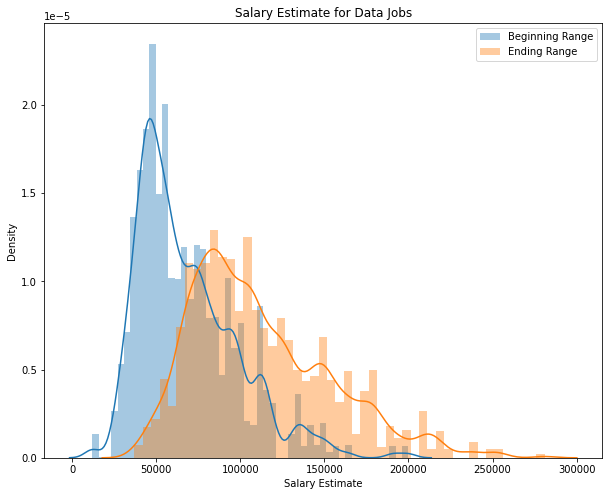

In [90]:
plt.figure(figsize = (10,8))
sns.distplot(df['Salary Estimate Beginning Range'], label = 'Beginning Range')
sns.distplot(df['Salary Estimate Ending Range'], label = 'Ending Range')
plt.title('Salary Estimate for Data Jobs')
plt.xlabel('Salary Estimate')
plt.legend()
plt.show();

The beginning salary estimate has a more steep slope than the ending salary estimate. The mean for the beginning and ending salary estimate is \$68,082 and \$111,910.

In [91]:
df['Salary Estimate Beginning Range'].describe()

count     12007.000000
mean      68082.735071
std       29640.633429
min       12000.000000
25%       46000.000000
50%       60000.000000
75%       85000.000000
max      200000.000000
Name: Salary Estimate Beginning Range, dtype: float64

In [92]:
df['Salary Estimate Ending Range'].describe()

count     12007.000000
mean     111910.612809
std       41789.351717
min       37000.000000
25%       81000.000000
50%      104000.000000
75%      139000.000000
max      281000.000000
Name: Salary Estimate Ending Range, dtype: float64

### Make `Job Description` lower case and get it's length

In [93]:
# make all of job description lowercase
# take out the labels in the job description column 
# take out the digits and _ in the job description column
# because then the corpus would have the labels that we want to guess
job_description_len = []
for i in range(len(df)):
    job_desc = df.loc[i,'Job Description'].lower()
    job_desc_without_label = re.sub(r'(data analyst)|(data scientist)|(data engineer)','',job_desc)
    replace = re.sub('[^a-zA-Z]', ' ',job_desc_without_label)
    df.loc[i,'Job Description'] = replace
    words = len(df.loc[i, 'Job Description'].split())
    job_description_len.append(words)
df['Job Description Length'] = job_description_len

### Extract level of seniority

In [94]:
# new column indicating entry level position
df.loc[:, 'entry'] = [(('intern' in x) | ('junior' in x) | ('trainee' in x) | ('coordinator' in x) | ('associate' in x)) for x in df['Job Description'].str.lower()]
# new column indicating mid-level position
df.loc[:, 'mid'] = [(('manager' in x) | ('lead' in x) | ('project' in x) | ('superintendent' in x) | ('supervisor' in x)) for x in df['Job Description'].str.lower()]
# new column indicating senior level position
df.loc[:, 'senior'] = [(('director' in x) | ('president' in x) | ('chief' in x) | ('head' in x) | ('senior' in x)) for x in df['Job Description'].str.lower()]

# given the number of jobs that fit into 2+ categories, not so sure this is the best approach for extracting the seniority of the position
# we recognize that the terms may show up in reference to who the position requires them to work with instead of the position itself
df.groupby(['entry', 'mid', 'senior']).count()[["Job Title"]]

Job Title
entry mid   senior           
False False False        1599
            True          365
      True  False        3357
            True         1455
True  False False         575
            True          207
      True  False        2511
            True         1984

Convert remaining -1 to Nan

In [95]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply,Label,Ordinal Revenue,Ordinal Size,Salary Estimate Beginning Range,Salary Estimate Ending Range,Job Description Length,entry,mid,senior
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True,Data Analyst,7.0,3.0,37000.0,66000.0,1017,True,True,False
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),overview provides analytical and technical su...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1,Data Analyst,10.0,7.0,37000.0,66000.0,613,True,True,False
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),we re looking for a senior who has a love of ...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1,Data Analyst,NaN,5.0,37000.0,66000.0,709,True,True,True
3,Data Analyst,$37K-$66K (Glassdoor est.),requisition numberrr remote yes we col...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1,Data Analyst,6.0,3.0,37000.0,66000.0,763,False,True,False
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),about fanduel group fanduel group is a world ...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True,Data Analyst,7.0,4.0,37000.0,66000.0,531,True,False,False


In [96]:
df['Easy Apply'] = df['Easy Apply'].replace('-1', False)
df = df.replace('-1', np.nan)
df = df.replace(-1, np.nan)

# Next Steps
- focus on exploratory analysis/unsupervised methods
- extracting useful features from `Job Description`

### Map company locations

In [97]:
unique_companies = df.drop_duplicates(subset=['Company Name', 'Location', 'Sector']).reset_index(drop=True)
unique_locations = unique_companies["Location"].unique()
len(unique_locations)

695

In [99]:
# turn each company's location into latitude/longitude coordinates for mapping
geolocator = Nominatim(user_agent="mapping-application")

latitudes=[]
longitudes=[]
for i in range(len(unique_locations)):
    location_string = unique_locations[i]
    if pd.isnull(location_string) or location_string == "Remote":
        latitudes.append(np.nan)
        longitudes.append(np.nan)
    else:
      location = geolocator.geocode(location_string, exactly_one=True)
      if location is None:
          latitudes.append(np.nan)
          longitudes.append(np.nan)
      else:
          latitudes.append(location.latitude)
          longitudes.append(location.longitude)
    if i % 50 == 0:
        print("Finished", i)

Finished 0
Finished 50
Finished 100
Finished 150
Finished 200
Finished 250
Finished 300
Finished 350
Finished 400
Finished 450
Finished 500


GeocoderTimedOut: ignored

In [ ]:
location_coords = pd.DataFrame({"location": unique_locations, "latitude": latitudes, "longitude": longitudes})
location_coords.head()

In [ ]:
# create a map for company locations
us_center = [39.8283, -98.5795]
location_map = folium.Map(location=us_center, tiles="OpenStreetMap", zoom_start=5)

# make a marker for each company location
for i in range(len(unique_locations)):
    coordinates = [location_coords.loc[i, 'latitude'], location_coords.loc[i, 'longitude']]
    if np.sum(np.isnan(coordinates)) > 0:
        continue
    popup = location_coords.loc[i, "location"]
    folium.Marker(location=coordinates, popup=popup, 
                  icon=folium.Icon(color="red", icon="building")).add_to(location_map)
    
# show the map
location_map

Salary by Job Type

In [ ]:
plt.figure(figsize = (10,8))
sns.displot(data=df,x = 'Salary Estimate Beginning Range', hue = 'Label', kind= 'kde')
plt.title('Salary Min Estimate for Data Jobs')
plt.xlabel('Salary Min Estimate')
plt.show()

Job Description Length by Job Type

In [ ]:
plt.figure(figsize = (10,8))
sns.displot(data=df,x = 'Job Description Length', hue = 'Label', kind= 'kde')
plt.title('Job Description Length for Data Jobs')
plt.xlabel('Job Description Length')
plt.show()

Stemming and Lemmatization

In [ ]:
lemmmatizer=WordNetLemmatizer()
lem_job = []
for k in range(df.shape[0]):
  sentences = df['Job Description'][k]
  words=word_tokenize(sentences)
  #List comprehension
  words = [lemmmatizer.lemmatize(word.lower()) for word in words if word not in set(stopwords.words('english'))]
  lem_sentences=' '.join(words)
  lem_job.append(lem_sentences)
df['Job Description Lem'] = lem_job

Converting Categorical Variables into Dummies

In [ ]:
df[['Label','Location']].value_counts()[:10]

In [ ]:
df[['Label','Sector']].value_counts()[:10]

In [ ]:
# years the company has existed
df['Years'] = 2020 - df['Founded'].astype('Int64')

In [ ]:
categorical = ['Sector']
numerical = df[['Rating','Years',
             'Salary Estimate Beginning Range', 'Job Description Length']]
normalized_num = (numerical-numerical.min())/(numerical.max()-numerical.min())
normalized_num['Scaled Revenue'] = (df['Ordinal Revenue'] - 1)/11
normalized_num['Scaled_Size'] = (df['Ordinal Size'] - 1)/6

dummied = pd.get_dummies(df[categorical])
df_new = pd.concat([normalized_num, dummied, df['Job Description Lem']], axis = 1)
df_new.head()


In [ ]:
df_matrix = np.matrix(df_new.values)

In [ ]:
df_new['Label'] = df['Label']

In [ ]:
df_new.to_csv('./classify_jobs.csv', index = False)